In [58]:
import os
from os import listdir
import numpy as np
import pickle as pkl

from utils import Person

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
basedir = '/Users/enea/Dropbox/Capocaccia2019_Gesture_DVS_Myo/Dataset/'
subject = '02'
session = '01'
file_name = f"subject{subject}_session{session}_davis.npz"

In [41]:
davis_data = np.load(basedir + file_name)
print(list(davis_data.keys()))
davis_frames = davis_data['frames']
print(davis_frames.shape)

['frames_time', 'dvs_events', 'frames']
(2016, 180, 240)


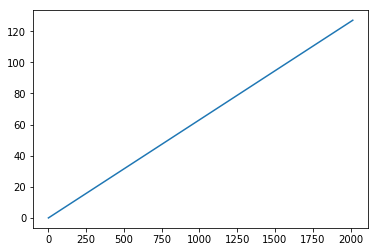

In [63]:
plt.plot(davis_data['frames_time'])

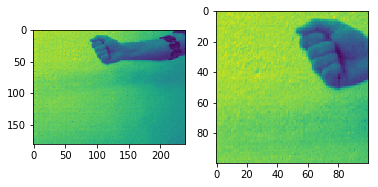

In [65]:
frame = davis_frames[2001].astype('float32')
frame -= np.min(frame)
frame /= np.max(frame)
frame = np.uint8(frame * 255)

# blurred = cv2.GaussianBlur(frame, (5, 5), 0)
# thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

M = cv2.moments(frame)
x = int(M["m10"] / M["m00"])
y = int(M["m01"] / M["m00"])

S = 100 // 2
sub_frame = frame[x - S + 20: x + S + 20, y - S: y + S]
fig, ax = plt.subplots(1,2)
ax[0].imshow(frame[::-1])
ax[1].imshow(sub_frame[::-1])

In [52]:
hog = cv2.HOGDescriptor((16, 16), (16, 16), (8, 8), (8, 8), 9); 

h = hog.compute(sub_frame)
print(h.shape)

(4356, 1)


In [90]:
# general stuff
fs = 200  # sampling frequency of MYO
VERBOSE = True
data_dir = '/Users/enea/Dropbox/Capocaccia2019_Gesture_DVS_Myo/Dataset/'
classes = classes = ['pinky', 'elle', 'yo', 'index', 'thumb']
classes_dict = {'pinky': 0, 'elle': 1, 'yo': 2, 'index': 3, 'thumb': 4}
classes_inv = {v: k for k, v in classes_dict.items()}

In [91]:
subjects = {}
names = [name for name in listdir(data_dir) if "emg" in name]
for name in names:
    _emg = np.load(data_dir + '{}'.format(name)).astype('float32')
    _ann = np.concatenate([np.array(['none']), np.load(data_dir + '{}'.format(name.replace("emg","ann")))[:-1]])
    
    subjects["_".join(name.split("_")[:2])] = Person(name.split("_")[0], _emg, _ann, classes=classes)
    
    if VERBOSE:
        print("Loaded {}: EMG = [{}] // ANN = [{}]".format("_".join(name.split("_")[:2]), _emg.shape, len(_ann)))
print("Data Loaded! {} Sessions".format(len(subjects.keys())))

# separates data in correct trial type
for name, data in subjects.items():
    for _class in classes:
        _annotation = np.float32(data.ann == _class)
        derivative = np.diff(_annotation)/1.0
        begins = np.where(derivative == 1)[0]
        ends = np.where(derivative == -1)[0]
        for b, e in zip(begins, ends):
            _trials = data.emg[b:e]
            data.trials[_class].append(_trials)
            data.begs[_class].append(b)
            data.ends[_class].append(e)
print("Done sorting trials!")

Loaded subject10_session03: EMG = [(25324, 8)] // ANN = [25324]
Loaded subject08_session02: EMG = [(25318, 8)] // ANN = [25318]
Loaded subject09_session03: EMG = [(25169, 8)] // ANN = [25169]
Loaded subject09_session02: EMG = [(23455, 8)] // ANN = [23455]
Loaded subject10_session02: EMG = [(25318, 8)] // ANN = [25318]
Loaded subject08_session03: EMG = [(25328, 8)] // ANN = [25328]
Loaded subject08_session01: EMG = [(25294, 8)] // ANN = [25294]
Loaded subject10_session01: EMG = [(25339, 8)] // ANN = [25339]
Loaded subject09_session01: EMG = [(25140, 8)] // ANN = [25140]
Loaded subject03_session03: EMG = [(25328, 8)] // ANN = [25328]
Loaded subject07_session02: EMG = [(25304, 8)] // ANN = [25304]
Loaded subject02_session02: EMG = [(25331, 8)] // ANN = [25331]
Loaded subject06_session03: EMG = [(24903, 8)] // ANN = [24903]
Loaded subject05_session01: EMG = [(25358, 8)] // ANN = [25358]
Loaded subject06_session02: EMG = [(24850, 8)] // ANN = [24850]
Loaded subject02_session03: EMG = [(2531

In [108]:
for subject, data in subjects.items():

    davis_data = np.load(basedir + f"{subject}_davis.npz")
    davis_frames = davis_data['frames']
    davis_times = davis_data['frames_time']
    S = 120 // 2
    
    for gesture in classes:
        for trial in range(5):
            print("{} :: {} :: {}".format(subject, gesture, trial))
            # load beginning and end 
            b = np.array(data.begs[gesture][trial]) / fs
            e = np.array(data.ends[gesture][trial]) / fs

            frame_size = 2
            shift = 0.
            beginning = b + shift
            ending = beginning + frame_size

            # slice
            sl = (davis_times > beginning) & (davis_times < ending)
            
            times = davis_times[sl]
            imgs = davis_frames[sl]
            
            _x = []
            _ts = []
            for frame, t in zip(imgs, times):
                frame = frame.astype('float32')
                frame -= np.min(frame)
                frame /= np.max(frame)
                frame = np.uint8(frame * 255)

                blurred = cv2.GaussianBlur(frame, (5, 5), 0)
                thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]
                
                M = cv2.moments(thresh)
                x = int(M["m10"] / M["m00"])
                y = int(M["m01"] / M["m00"])

                sub_frame = frame[x - S: x + S, y - S: y + S]

                _x.append(sub_frame)
                _ts.append(t - times[0])
                
            ff = np.array(_x)
            ll = np.array(_ts)

            data.x[gesture].append(ff)
            data.ts[gesture].append(ll)

subject10_session03 :: pinky :: 0
subject10_session03 :: pinky :: 1
subject10_session03 :: pinky :: 2
subject10_session03 :: pinky :: 3
subject10_session03 :: pinky :: 4
subject10_session03 :: elle :: 0
subject10_session03 :: elle :: 1
subject10_session03 :: elle :: 2
subject10_session03 :: elle :: 3
subject10_session03 :: elle :: 4
subject10_session03 :: yo :: 0
subject10_session03 :: yo :: 1
subject10_session03 :: yo :: 2
subject10_session03 :: yo :: 3
subject10_session03 :: yo :: 4
subject10_session03 :: index :: 0
subject10_session03 :: index :: 1
subject10_session03 :: index :: 2
subject10_session03 :: index :: 3
subject10_session03 :: index :: 4
subject10_session03 :: thumb :: 0
subject10_session03 :: thumb :: 1
subject10_session03 :: thumb :: 2
subject10_session03 :: thumb :: 3
subject10_session03 :: thumb :: 4
subject08_session02 :: pinky :: 0
subject08_session02 :: pinky :: 1
subject08_session02 :: pinky :: 2
subject08_session02 :: pinky :: 3
subject08_session02 :: pinky :: 4


subject03_session03 :: thumb :: 3
subject03_session03 :: thumb :: 4
subject07_session02 :: pinky :: 0
subject07_session02 :: pinky :: 1
subject07_session02 :: pinky :: 2
subject07_session02 :: pinky :: 3
subject07_session02 :: pinky :: 4
subject07_session02 :: elle :: 0
subject07_session02 :: elle :: 1
subject07_session02 :: elle :: 2
subject07_session02 :: elle :: 3
subject07_session02 :: elle :: 4
subject07_session02 :: yo :: 0
subject07_session02 :: yo :: 1
subject07_session02 :: yo :: 2
subject07_session02 :: yo :: 3
subject07_session02 :: yo :: 4
subject07_session02 :: index :: 0
subject07_session02 :: index :: 1
subject07_session02 :: index :: 2
subject07_session02 :: index :: 3
subject07_session02 :: index :: 4
subject07_session02 :: thumb :: 0
subject07_session02 :: thumb :: 1
subject07_session02 :: thumb :: 2
subject07_session02 :: thumb :: 3
subject07_session02 :: thumb :: 4
subject02_session02 :: pinky :: 0
subject02_session02 :: pinky :: 1
subject02_session02 :: pinky :: 2


subject05_session02 :: pinky :: 0
subject05_session02 :: pinky :: 1
subject05_session02 :: pinky :: 2
subject05_session02 :: pinky :: 3
subject05_session02 :: pinky :: 4
subject05_session02 :: elle :: 0
subject05_session02 :: elle :: 1
subject05_session02 :: elle :: 2
subject05_session02 :: elle :: 3
subject05_session02 :: elle :: 4
subject05_session02 :: yo :: 0
subject05_session02 :: yo :: 1
subject05_session02 :: yo :: 2
subject05_session02 :: yo :: 3
subject05_session02 :: yo :: 4
subject05_session02 :: index :: 0
subject05_session02 :: index :: 1
subject05_session02 :: index :: 2
subject05_session02 :: index :: 3
subject05_session02 :: index :: 4
subject05_session02 :: thumb :: 0
subject05_session02 :: thumb :: 1
subject05_session02 :: thumb :: 2
subject05_session02 :: thumb :: 3
subject05_session02 :: thumb :: 4
subject01_session03 :: pinky :: 0
subject01_session03 :: pinky :: 1
subject01_session03 :: pinky :: 2
subject01_session03 :: pinky :: 3
subject01_session03 :: pinky :: 4


In [109]:
X1 = []
X2 = []
Y = []

for subject, sub in subjects.items():
    for gesture in classes:
        for trial in range(5):

            _emg = sub.trials[gesture][trial]

            if _emg.shape[0] < 400:
                _emg = np.vstack([_emg, np.zeros((400 - _emg.shape[0], 8))])
            _emg = _emg[80:400]
            X2.append(_emg.reshape(-1, 40, 8))

            _x = sub.x[gesture][trial]
            _ts = sub.ts[gesture][trial]
            for i in [0.4, 0.6, 0.8, 1., 1.2, 1.4, 1.6, 1.8]:
                fil = (_ts > i) & (_ts < i + 0.2)
                if len(_x[fil].shape) > 1:
                    frame = np.mean(_x[fil], 0)
                    X1.append(frame)
                    Y.append(classes_dict[gesture])

In [110]:
print(len(X1))

5160


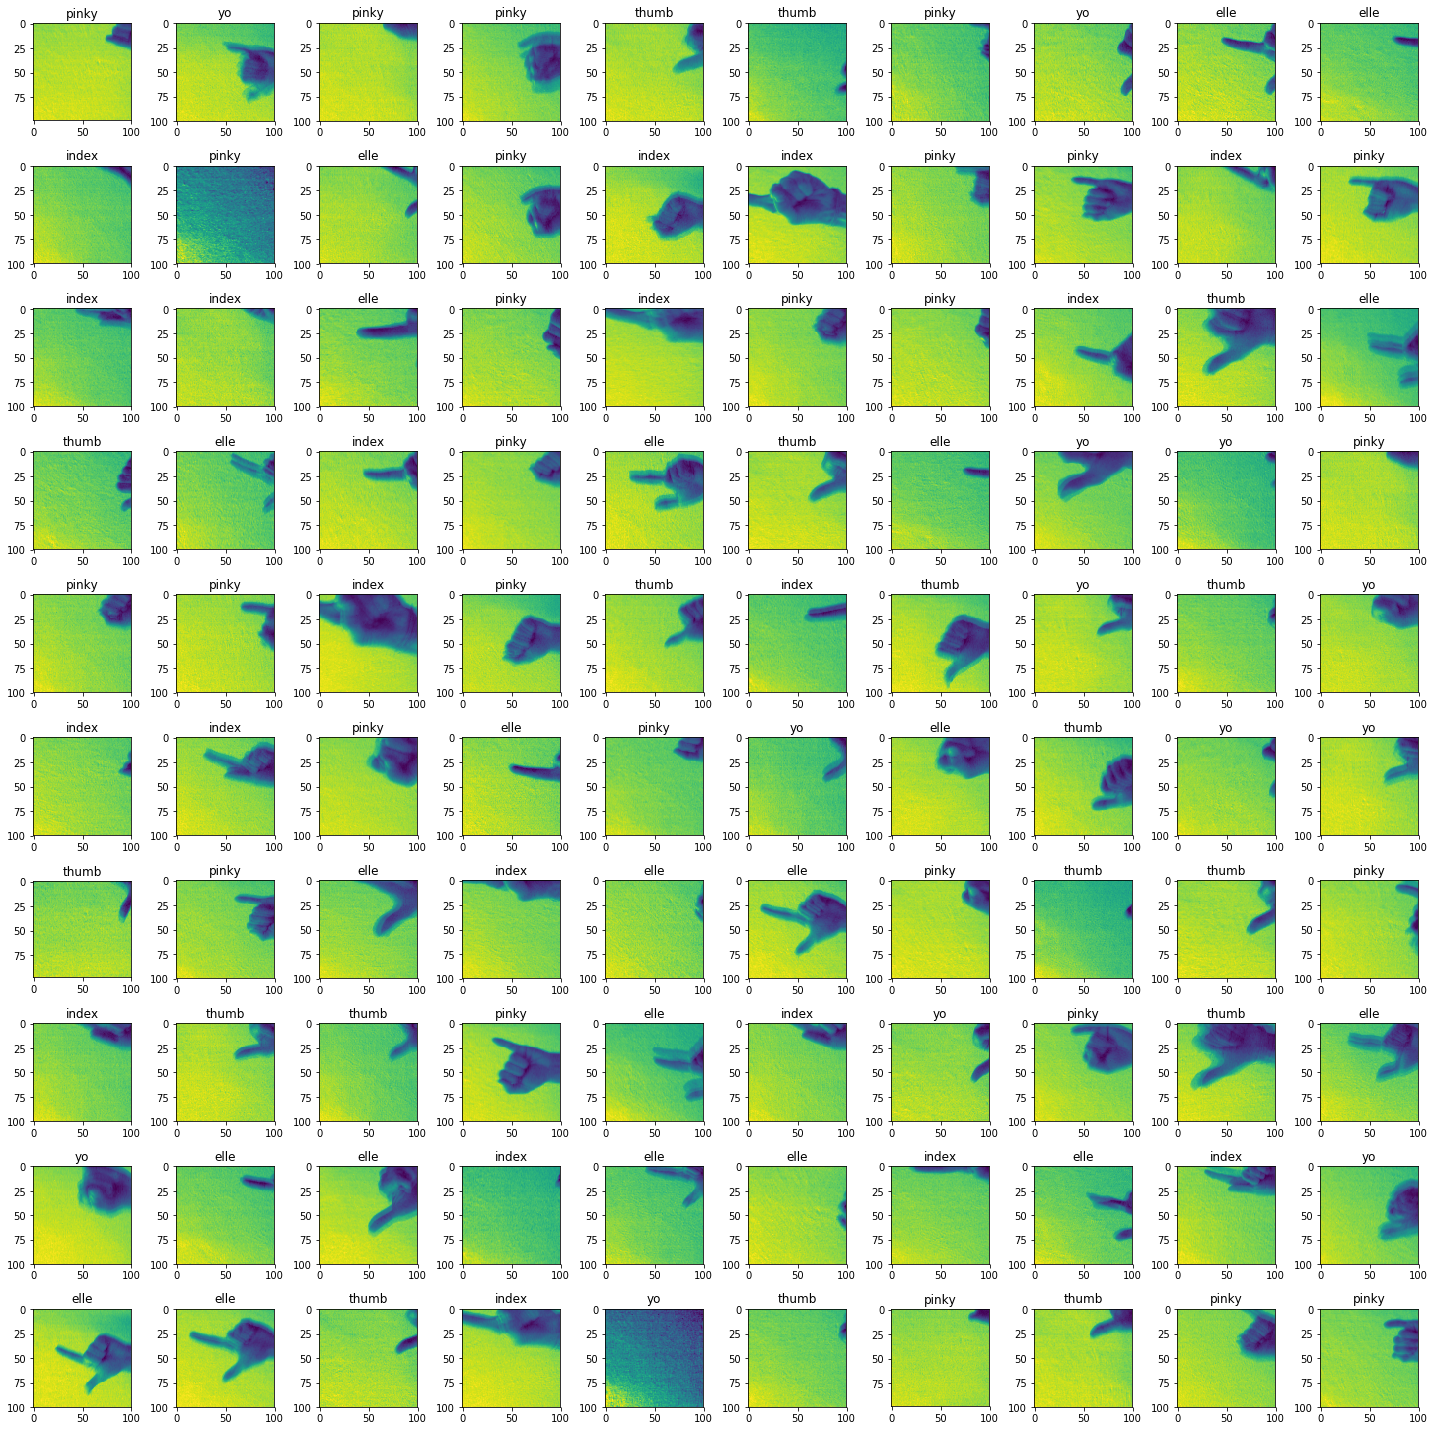

In [112]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        _idx = np.random.randint(5100)
        a = X1[_idx]
        a -= np.min(a)
        a /= np.max(a)
        frame = np.uint8(a * 255)
        ax[i][j].imshow(frame)
        ax[i][j].set_title(classes_inv[Y[_idx]])

plt.tight_layout()
# plt.savefig('example_dataset.pdf')